# Analysis of Successful Movies (Notebook 3)
* Benjamin Grossmann

This notebook goes through a little Exploratory Data Analysis (EDA) using the data retrieved from Notebook 2.

# Initial Imports and Loads

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# open saved csv.gz files of from tmdb data
df_2000 = pd.read_csv('Data/tmdb_data_2000.csv.gz', low_memory = False)
df_2001 = pd.read_csv('Data/tmdb_data_2001.csv.gz', low_memory = False)

In [3]:
df = pd.concat([df_2000,df_2001], ignore_index=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2476 entries, 0 to 2475
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2476 non-null   object 
 1   adult                  2476 non-null   float64
 2   backdrop_path          1256 non-null   object 
 3   belongs_to_collection  195 non-null    object 
 4   budget                 2476 non-null   float64
 5   genres                 2476 non-null   object 
 6   homepage               173 non-null    object 
 7   id                     2476 non-null   float64
 8   original_language      2476 non-null   object 
 9   original_title         2476 non-null   object 
 10  overview               2423 non-null   object 
 11  popularity             2476 non-null   float64
 12  poster_path            2169 non-null   object 
 13  production_companies   2476 non-null   object 
 14  production_countries   2476 non-null   object 
 15  rele

# Budget and Revenue

In [5]:
print(f"{df['budget'].isna().sum()} missing values for budget.")
print(f"{df['revenue'].isna().sum()} missing values for revenue.")

0 missing values for budget.
0 missing values for revenue.


In [6]:
df[['budget','revenue']].describe()

,budget,revenue
count,2.476000e+03,2.476000e+03
mean,5.389631e+06,1.125107e+07
std,1.734807e+07,5.326838e+07
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.400000e+08,9.764756e+08


The minimum values in both columns are zeros...over 75% of the values in both columns are zeros. This means there must be movies that have zero for both budget and revenue. Since these movies can't provide any help with determining what makes a financially successful movie, I will have to remove them from the analysis. Let's see how many we are going to lose.

In [7]:
print(len(df.loc[(df['budget']==0) & (df['revenue']==0),:]), "movies with budget and revenue given as 0")
print(len(df.loc[(df['budget']>0) | (df['revenue']>0),:]), "movies with a known budget OR revenue greater than 0")
print(f"     ({len(df.loc[(df['budget']==0) & (df['revenue']>0),:])} with budget given as 0)")
print(f"     ({len(df.loc[(df['budget']>0) & (df['revenue']==0),:])} with revenue given as 0)")
print(f"     ({len(df.loc[(df['budget']>0) & (df['revenue']>0),:])} budget AND revenue greater than 0)")

1860 movies with budget and revenue given as 0
616 movies with a known budget OR revenue greater than 0
     (80 with budget given as 0)
     (190 with revenue given as 0)
     (346 budget AND revenue greater than 0)


In [8]:
df = df.loc[(df['budget']>0) | (df['revenue']>0),:]
df.shape

(616, 26)

In [9]:
df[['budget','revenue']].describe()

,budget,revenue
count,6.160000e+02,6.160000e+02
mean,2.166352e+07,4.522347e+07
std,2.929232e+07,9.940040e+07
min,0.000000e+00,0.000000e+00
25%,7.000000e+05,0.000000e+00
50%,8.500000e+06,3.137902e+06
75%,3.000000e+07,3.952534e+07
max,1.400000e+08,9.764756e+08


There are still some zero values present in either column, but never both columns at the same time.

#  Certification Categories

I can split the data into certification categories, and see how many are in each category.

In [10]:
df.groupby(['certification'],dropna=False)['imdb_id'].count().reset_index(name='count')

,certification,count
0,G,14
1,NR,17
2,PG,35
3,PG-13,130
4,R,226
5,NaN,194


Now to add the remaining numerical information to this table.

In [11]:
certification_means = df.groupby(['certification'],dropna=False).mean().reset_index().merge(
    df.groupby(['certification'],dropna=False)['imdb_id'].count().reset_index(name='count'),
    on='certification')
certification_means

,certification,adult,budget,id,popularity,revenue,runtime,video,vote_average,vote_count,count
0,G,0.0,4.085714e+07,17450.500000,37.158214,1.237085e+08,85.928571,0.0,6.407143,2368.000000,14
1,NR,0.0,6.388241e+06,73369.529412,10.295941,8.887611e+06,101.882353,0.0,6.035294,426.588235,17
2,PG,0.0,4.497857e+07,35638.571429,32.933343,1.123378e+08,103.228571,0.0,6.154286,2394.600000,35
3,PG-13,0.0,4.348391e+07,15475.900000,14.789169,9.957933e+07,109.169231,0.0,6.099231,1685.884615,130
4,R,0.0,2.028827e+07,24560.265487,12.014265,3.324591e+07,105.765487,0.0,5.984071,929.380531,226
5,NaN,0.0,4.390831e+06,113219.664948,4.441897,8.164620e+06,101.211340,0.0,5.119072,228.706186,194


Since we are only interested in G/PG/PG-13/R, the other ratings can be dropped. I will also drop the columns that are all zeros and the id column because its average has no meaning.

In [12]:
certification_filter = (certification_means['certification']=='G')|(
    certification_means['certification']=='PG')|(
    certification_means['certification']=='PG-13')|(
    certification_means['certification']=='R')

certification_means = certification_means.loc[ certification_filter,:  ].drop(columns=['id','adult','video'])

certification_means

,certification,budget,popularity,revenue,runtime,vote_average,vote_count,count
0,G,4.085714e+07,37.158214,1.237085e+08,85.928571,6.407143,2368.000000,14
2,PG,4.497857e+07,32.933343,1.123378e+08,103.228571,6.154286,2394.600000,35
3,PG-13,4.348391e+07,14.789169,9.957933e+07,109.169231,6.099231,1685.884615,130
4,R,2.028827e+07,12.014265,3.324591e+07,105.765487,5.984071,929.380531,226


The number of movies in each certification category:
* G: 14
* PG: 35
* PG-13: 130
* R: 226


The average budget for each certification category:
* G: \$ 40.86 Million
* PG: \$ 44.98 Million
* PG-13: \$ 43.48 Million
* R: \$ 20.29 Million

The average revenue for each certification category:
* G: \$ 123.71 Million
* PG: \$ 112.33 Million
* PG-13: \$ 99.58 Million
* R: \$ 33.25 Million

We can see how these financial numbers compare in the graphs below.

# Visualizations

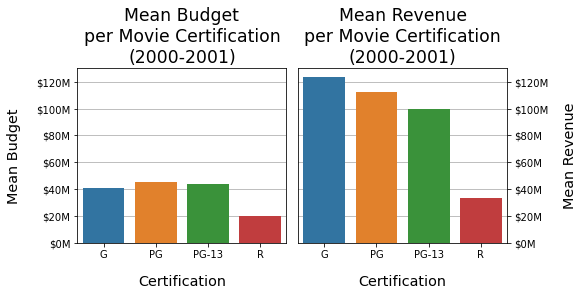

In [29]:
from matplotlib.ticker import FuncFormatter

# define the format
def mdollar(x,pos):
    # function for use wth matplotlib FuncFormatter -  formats money in millions
    return f"${x*1e-6:,.0f}M"
# create the formatter

mdollar_formatter = FuncFormatter(mdollar)

fig, axe = plt.subplots(ncols = 2, figsize=(8,4),constrained_layout=True)

sns.barplot(ax = axe[0],
            data = certification_means,
            x = 'certification',
            y = 'budget',
           zorder=3)
sns.barplot(ax = axe[1],
            data = certification_means,
            x = 'certification',
            y = 'revenue',
           zorder=3)
axe[0].set_xlabel('Certification', labelpad=15, fontsize='x-large')
axe[0].set_ylabel('Mean Budget', labelpad=15, fontsize='x-large')
axe[0].yaxis.set_major_formatter(mdollar_formatter)
axe[1].set_xlabel('Certification', labelpad=15, fontsize='x-large')
axe[1].set_ylabel('Mean Revenue', labelpad=15, fontsize='x-large')
axe[1].yaxis.set_major_formatter(mdollar_formatter)
axe[1].yaxis.set_label_position('right')
axe[1].yaxis.tick_right()
axe[0].set_title('Mean Budget\nper Movie Certification\n(2000-2001)', fontsize='xx-large')
axe[1].set_title('Mean Revenue\nper Movie Certification\n(2000-2001)', fontsize='xx-large')
axe[0].yaxis.grid(True,zorder=1)
axe[1].yaxis.grid(True,zorder=1)
axe[0].set(ylim=(0,130000000))
axe[1].set(ylim=(0,130000000))
plt.show()

We can also see a comparison of the revenue to the budget of each movie individually.

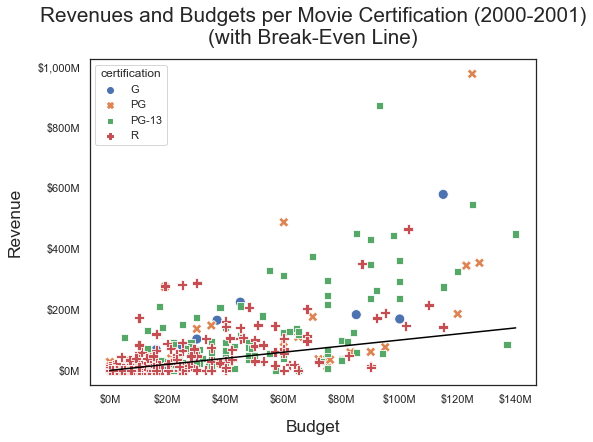

In [39]:
plt.figure(figsize=(8,6))
certification_filter = (df['certification']=='G')|(
    df['certification']=='PG')|(
    df['certification']=='PG-13')|(
    df['certification']=='R')

axe = sns.scatterplot(data = df[certification_filter].sort_values(by='certification'),
                      x = 'budget',
                      y = 'revenue',
                      hue='certification',
                      style='certification',
                      s=100)
axe.set_xlabel('Budget', labelpad=15, fontsize='x-large')
axe.set_ylabel('Revenue', labelpad=15, fontsize='x-large')
axe.plot([0,140000000],[0,140000000],color='black')
# axe.plot([0,140000000],[0,280000000])
# axe.plot([0,140000000],[0,420000000])
# axe.plot([0,140000000],[0,590000000])
axe.xaxis.set_major_formatter(mdollar_formatter)
axe.yaxis.set_major_formatter(mdollar_formatter)
axe.set_title('Revenues and Budgets per Movie Certification (2000-2001)\n(with Break-Even Line)', fontsize='xx-large',pad=15)
# axe.set(xscale='log',yscale='log')
plt.show()

In [19]:
df['r_to_b_ratio']=df['revenue']/df['budget']

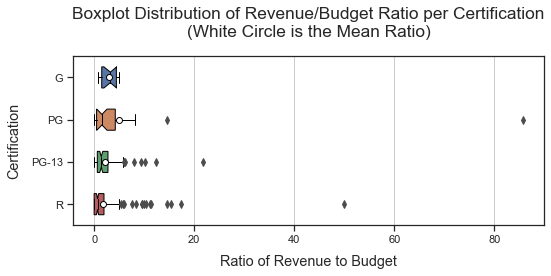

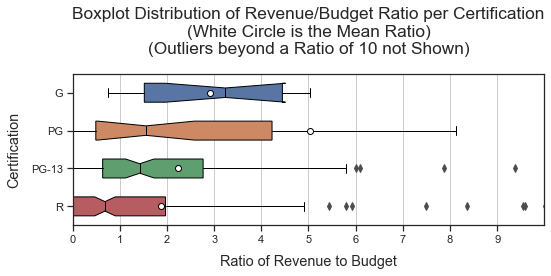

In [62]:
plt.figure(figsize=(8,4),tight_layout=True)
# sns.set(style="white")
axe = sns.boxplot(data=df[certification_filter][df[certification_filter]['budget']!=0].sort_values(by='certification') ,x="r_to_b_ratio",y="certification", notch=True,\
            width=0.5,\
            linewidth=1,\
            showmeans=True,\
            dodge=False,\
            flierprops=dict(marker="d",color="black"),\
            capprops=dict(color="black"),\
            whiskerprops=dict(color="black"),\
            boxprops=dict(edgecolor="black"),\
            medianprops=dict(color="black"),\
            meanprops=dict(color="black",marker="o",markerfacecolor="white",markeredgecolor="black"))
# axe.set_xlim(0,10);
# axe.set_xticks(range(0,10,1));
axe.tick_params(bottom=True,left=True)
axe.set_title("Boxplot Distribution of Revenue/Budget Ratio per Certification\n(White Circle is the Mean Ratio)",fontsize="x-large",pad=20);
axe.set_xlabel("Ratio of Revenue to Budget",fontsize="large",labelpad=10);
axe.set_ylabel("Certification",fontsize="large",labelpad=10);
axe.xaxis.grid(True);
# axe.set(xscale='log')
plt.show()

plt.figure(figsize=(8,4),tight_layout=True)
# sns.set(style="white")
axe = sns.boxplot(data=df[certification_filter][df[certification_filter]['budget']!=0].sort_values(by='certification') ,x="r_to_b_ratio",y="certification", notch=True,\
            width=0.5,\
            linewidth=1,\
            showmeans=True,\
            dodge=False,\
            flierprops=dict(marker="d",color="black"),\
            capprops=dict(color="black"),\
            whiskerprops=dict(color="black"),\
            boxprops=dict(edgecolor="black"),\
            medianprops=dict(color="black"),\
            meanprops=dict(color="black",marker="o",markerfacecolor="white",markeredgecolor="black"))
axe.set_xlim(0,10);
axe.set_xticks(range(0,10,1));
axe.tick_params(bottom=True,left=True)
axe.set_title("Boxplot Distribution of Revenue/Budget Ratio per Certification\n(White Circle is the Mean Ratio)\n(Outliers beyond a Ratio of 10 not Shown)",fontsize="x-large",pad=20);
axe.set_xlabel("Ratio of Revenue to Budget",fontsize="large",labelpad=10);
axe.set_ylabel("Certification",fontsize="large",labelpad=10);
axe.xaxis.grid(True);
# axe.set(xscale='log')
plt.show()

Although most movies being examined in this data set have ratios greater than 1 (revenue is greater than budget), the R certification as a sub-group of movies leans the other way.

Most movies also have a smaller ratio than the mean value in their certification category, except the G certification sub-group.  This is because the mean values are being skewed by extreme outliers.